# Cluster the users in hopes of localizing search
main author: Daniel Li

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

#### use the code from the other notebook to load and clean data

In [4]:
# Load datasets
ratings = pd.read_csv('book_ratings.csv')
history = pd.read_csv('book_history.csv')
items = pd.read_csv('items_info.csv')
users = pd.read_csv('users_info.csv')

# 🔍 Step 1: Clean Ratings
ratings.drop_duplicates(inplace=True)
ratings = ratings.dropna(subset=['user', 'item', 'rating'])

# 🔍 Step 2: Clean History
history.drop_duplicates(inplace=True)
history = history.dropna(subset=['user', 'item', 'accessed'])

# 🔍 Step 3: Clean Items
items.drop_duplicates(subset=['Book_ID', 'ISBN'], inplace=True)

# Fix types
items['Year-Of-Publication'] = pd.to_numeric(items['Year-Of-Publication'], errors='coerce')
items['Year-Of-Publication'] = items['Year-Of-Publication'].fillna(0).astype(int)
items['Publisher'] = items['Publisher'].fillna('Unknown')
items['Book-Title'] = items['Book-Title'].fillna('Unknown')
items['Book-Author'] = items['Book-Author'].fillna('Unknown')

# 🔍 Step 4: Clean Users
users.drop_duplicates(inplace=True)
users['Age'] = pd.to_numeric(users['Age'], errors='coerce')
users.loc[(users['Age'] < 10) | (users['Age'] > 90), 'Age'] = users["Age"].median()

# # 🧾 Step 5: Print final structure
# print("✅ Cleaned Shapes:")
# print("Ratings:", ratings.shape)
# print("History:", history.shape)
# print("Items:", items.shape)
# print("Users:", users.shape)

# print("\n🔹 Ratings (head):")
# print(ratings.head())

# print("\n🔹 History (head):")
# print(history.head())

# print("\n🔹 Items (head):")
# print(items[['Book_ID', 'ISBN', 'Book-Title', 'Book-Author', 'Year-Of-Publication']].head())

# print("\n🔹 Users (head):")
# print(users.head())


In [5]:
# Create user-item rating matrix (users as rows, items as columns)
user_item_matrix = ratings.pivot(index='user', columns='item', values='rating')

In [6]:
user_item_matrix.index

Index([   1,    2,    5,    7,    9,   11,   14,   16,   18,   20,
       ...
       2924, 2925, 2927, 2928, 2930, 2937, 2939, 2942, 2943, 2945],
      dtype='int64', name='user', length=1295)

In [7]:
user_item_matrix.shape

(1295, 14684)

In [8]:
user_item_matrix.head()

item,1,2,3,4,5,6,7,8,9,10,...,17367,17369,17370,17371,17372,17373,17374,17378,17379,17384
user,,,,,,,,,,,,,,,,,,,,,
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [9]:
filled_matrix = user_item_matrix.fillna(0)

#### Visualize the data with the first two PCs through PCA. There is no clear intuitive clusters from the visualization.

In [11]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X_pca = pca.fit_transform(filled_matrix)

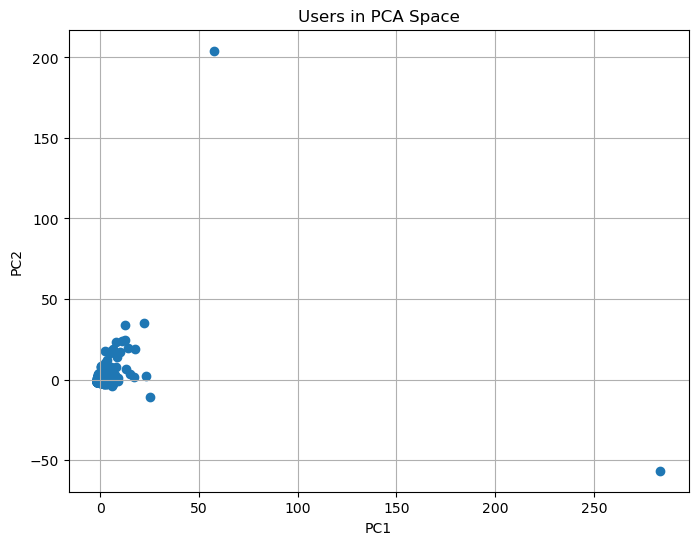

In [12]:
plt.figure(figsize=(8, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1])
plt.title("Users in PCA Space")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.grid(True)
plt.show()

#### Try applying SVD and vary the number of components in SVD to see what number captures enough variance

In [14]:
from sklearn.decomposition import TruncatedSVD

In [15]:
max_components = filled_matrix.shape[1]
explained_variances = []

# Test a range of component values
for n in range(1, 1000, 50):
    svd = TruncatedSVD(n_components=n, random_state=42)
    svd.fit(filled_matrix)
    explained_variances.append(np.sum(svd.explained_variance_ratio_))


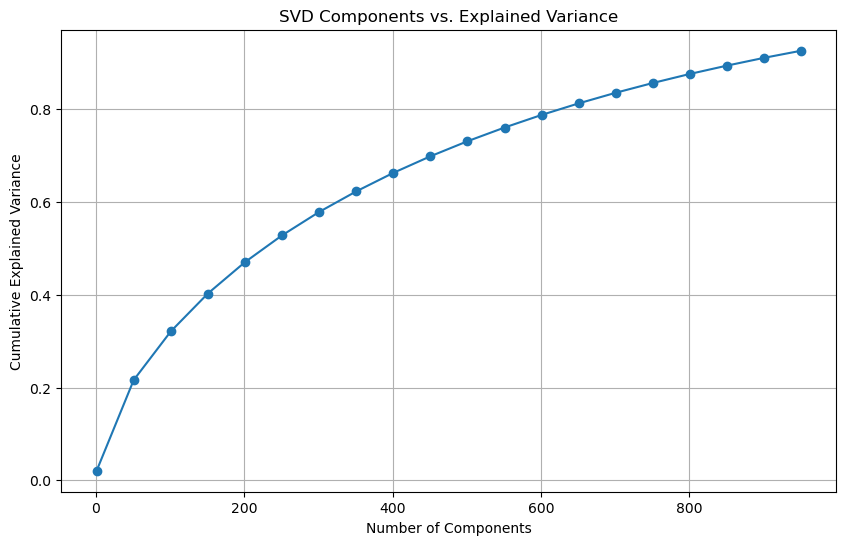

In [16]:
# Plotting cumulative explained variance
plt.figure(figsize=(10, 6))
plt.plot(range(1, 1000,50), explained_variances, marker='o')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('SVD Components vs. Explained Variance')
plt.grid(True)
plt.show()

#### the plot above shows that around 600 components (out of 15000) captures about 80% of the variance

In [18]:
svd_optimal = TruncatedSVD(n_components=600, random_state=42)
svd_optimal.fit(filled_matrix)

TruncatedSVD(n_components=600, random_state=42)

In [19]:
user_item_svd = svd_optimal.transform(filled_matrix)

#### Similarly, there are no clear intuitive clusters even after performing SVD. This is expected with sparse data and not ideal with what we are trying to achieve by clustering. 

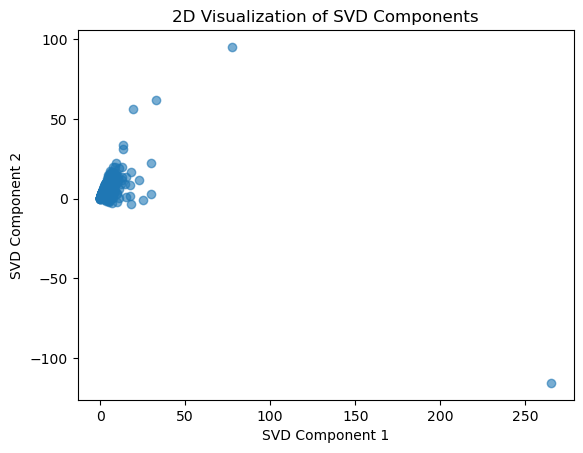

In [21]:
plt.scatter(user_item_svd[:, 0], user_item_svd[:, 1], alpha=0.6)
plt.xlabel('SVD Component 1')
plt.ylabel('SVD Component 2')
plt.title('2D Visualization of SVD Components')
plt.show()

#### combine user info with SVD user item matrix to perform clustering

In [23]:
from sklearn.preprocessing import OneHotEncoder



In [24]:
relevant_users = users[users["User-ID"].isin(user_item_matrix.index)]

In [25]:
relevant_users.shape

(1295, 3)

In [26]:
relevant_users["Location"].unique().shape

(916,)

In [27]:
user_item_svd.shape

(1295, 600)

#### There are only 1295 users in our matrix, but 916 unique cities, this will increase our dimensionality for clustering. Trying PCA, it still needs 851 components to capture 95% variance. 

In [29]:
encoder = OneHotEncoder()

user_locations = encoder.fit_transform(relevant_users[["Location"]])

In [30]:
user_locations_dense = user_locations.toarray()

In [31]:
from sklearn import decomposition

In [32]:
pca = decomposition.PCA()
user_location_pca = pca.fit_transform(user_locations_dense)

In [33]:
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)

In [34]:
n_components_95 = np.argmax(cumulative_variance >= 0.95) + 1
n_components_95

851

In [35]:
user_ages = relevant_users["Age"].to_numpy()

In [36]:
user_items_city_age = np.hstack([user_item_svd, user_locations_dense, user_ages.reshape(-1, 1)])

In [37]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
user_normalized = scaler.fit_transform(user_items_city_age) 

In [38]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

sil_scores = []
K_range = range(2, 30)

for k in K_range:
    kmeans = KMeans(n_clusters=k)
    labels = kmeans.fit_predict(user_normalized)
    score = silhouette_score(user_normalized, labels)
    sil_scores.append(score)

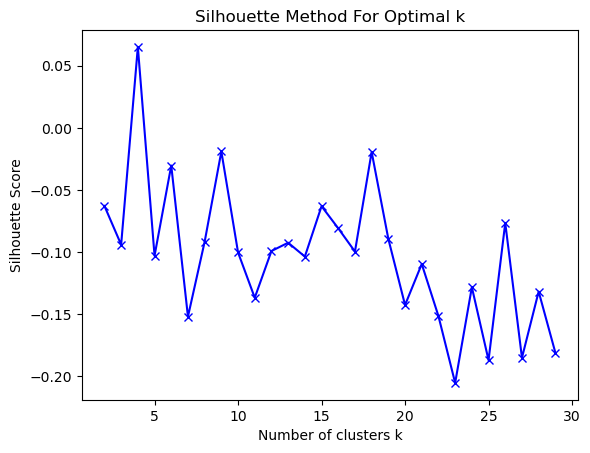

In [39]:
plt.plot(K_range, sil_scores, 'bx-')
plt.xlabel('Number of clusters k')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Method For Optimal k')
plt.show()

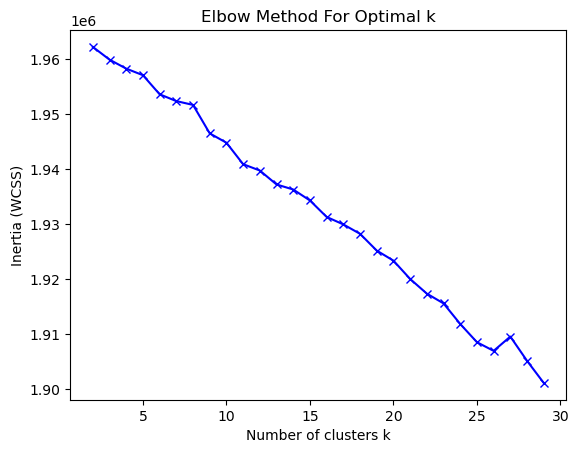

In [40]:
inertia = []

for k in K_range:
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(user_normalized)
    inertia.append(kmeans.inertia_)

plt.plot(K_range, inertia, 'bx-')
plt.xlabel('Number of clusters k')
plt.ylabel('Inertia (WCSS)')
plt.title('Elbow Method For Optimal k')
plt.show()

#### SKLearn's clustering uses Euclidean distance, try implementing the kmeans function provided in class to apply with cosine function

In [42]:
from numpy import *

def dist_cosine(vecA, vecB):
    # first find the vector norm for each instance in D as well as the norm for vector x
    vecA_norm = np.linalg.norm(vecA)
    vecB_norm = np.linalg.norm(vecB)
    # Compute Cosine: divide the dot product o x and each instance in D by the product of the two norms
    sims = np.dot(vecA, vecB)/(vecA_norm * vecB_norm)
    # The distance measure will be the inverse of Cosine similarity
    dists = 1 - sims
    return dists
def randCent(dataSet, k):
	n = shape(dataSet)[1]
	centroids = zeros((k,n), dtype=float)
	for j in range(n): #create random cluster centers
		minJ = min(dataSet[:,j])
		rangeJ = float(max(dataSet[:,j]) - minJ)
		centroids[:,j] = minJ + rangeJ * random.rand(k)
	return centroids 

# kMeans function
def kMeans(dataSet, k, distMeas=dist_cosine, createCent=randCent):
    m = shape(dataSet)[0]
    clusterAssment = zeros((m,2)) #create mat to assign data points 
                                  #to a centroid, also holds SE of each point
    centroids = createCent(dataSet, k)
    clusterChanged = True
    while clusterChanged:
        clusterChanged = False
        for i in range(m): #for each data point assign it to the closest centroid
            minDist = inf; minIndex = -1
            for j in range(k):
                distJI = distMeas(centroids[j,:],dataSet[i,:])
                if distJI < minDist:
                    minDist = distJI; minIndex = j
            if clusterAssment[i,0] != minIndex: clusterChanged = True
            clusterAssment[i,:] = minIndex,minDist**2
        # print centroids
        for cent in range(k):#recalculate centroids
            ptsInClust = dataSet[nonzero(clusterAssment[:,0]==cent)[0]] #get all the point in this cluster - Note: this was incorrect in the original distribution.
            if(len(ptsInClust)!=0):
                centroids[cent,:] = mean(ptsInClust, axis=0) #assign centroid to mean - Note condition was added 10/28/2013
    return centroids, clusterAssment

In [43]:
def calculate_wss(X, labels, centroids):
    wss = 0.0
    for i, centroid in enumerate(centroids):
        # Get all points in cluster i
        cluster_points = X[labels == i]
        # Compute squared distances to centroid
        distances = np.linalg.norm(cluster_points - centroid, axis=1)
        wss += np.sum(distances ** 2)
    return wss

In [44]:
user_centroids, user_clusters = kMeans(user_normalized, 2, distMeas = dist_cosine, createCent=randCent)

In [45]:
score = silhouette_score(user_normalized, user_clusters[:,0], metric='cosine')

In [46]:
sil_score = []
wss_score = []
for i in K_range:
    user_centroids, user_clusters = kMeans(user_normalized, i, distMeas = dist_cosine, createCent=randCent)
    sil = silhouette_score(user_normalized, user_clusters[:,0], metric='cosine')
    sil_score.append(sil)
    wss = calculate_wss(user_normalized, user_clusters[:,0], user_centroids)
    wss_score.append(wss)

#### The silhoutte score plot suggests poor clustering and no clear clusters. Same for the elbow plot, no clear elbow is shown and just a straight decreasing line. These were similar results to kmeans with Euclidean distance. 

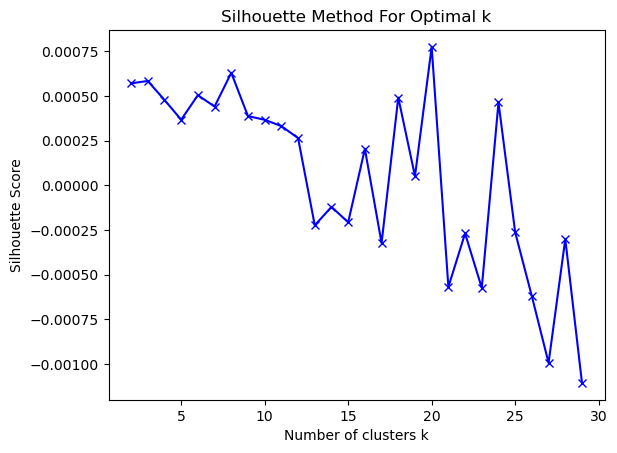

In [48]:
plt.plot(K_range, sil_score, 'bx-')
plt.xlabel('Number of clusters k')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Method For Optimal k')
plt.show()

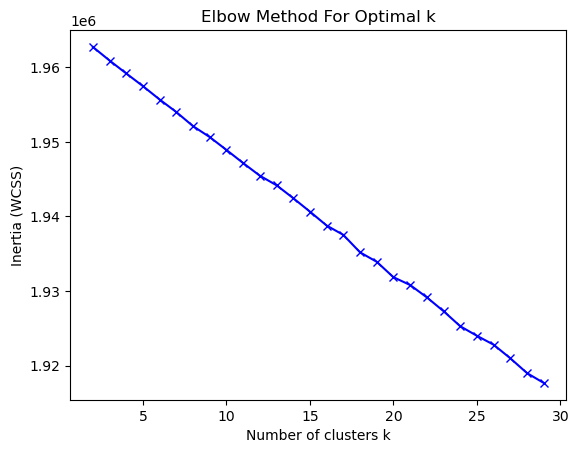

In [49]:
plt.plot(K_range, wss_score, 'bx-')
plt.xlabel('Number of clusters k')
plt.ylabel('Inertia (WCSS)')
plt.title('Elbow Method For Optimal k')
plt.show()

#### Try using DBSCAN. Even with DBSCAN, it still classifies a lot points as noise

In [51]:
from sklearn.cluster import DBSCAN
dbscan = DBSCAN(eps=20, min_samples=5)
clusters = dbscan.fit_predict(user_normalized)

In [52]:
cluster_labels = set(clusters)

In [53]:
cluster_labels

{-1, 0, 1}

In [54]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(user_normalized)

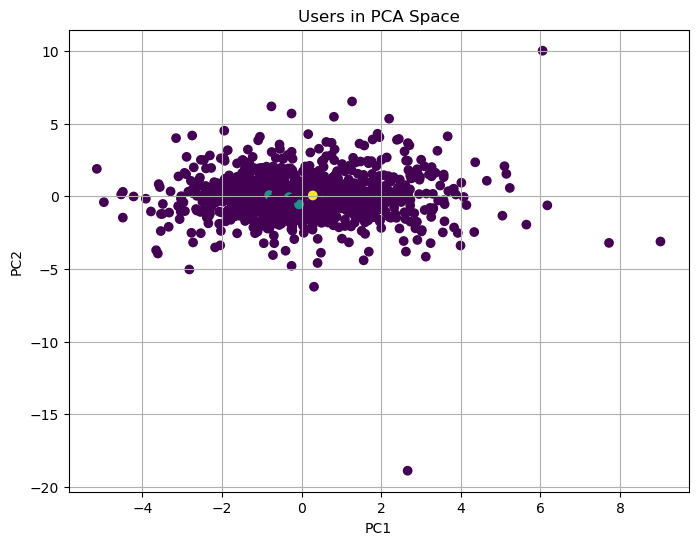

In [55]:
plt.figure(figsize=(8, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c = clusters)
plt.title("Users in PCA Space")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.grid(True)
plt.show()

#### Due to the nature of our data, clustering to localized might not be applicable as there are no clear and good clusters found. 